In [41]:
print("Welcome to Housing Prices Predicting!")

Welcome to Housing Prices Predicting!


This project requires Python 3.7 or above:


In [42]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:


In [43]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Get the Data


We want to predict median house values in Californian districts, given a number of features from these districts.


## Download the Data


In [44]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("./datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("./datasets").mkdir(parents=True, exist_ok=True) # ensures the existence of a directory named datasets.
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            # extracts housing.tgz content into the datasets directory;
            # this creates the datasets/housing directory with the housing.csv file inside it.
            housing_tarball.extractall(path="./datasets") 
    return pd.read_csv(Path("./datasets/housing/housing.csv"))

housing = load_housing_data()
print(type(housing))

<class 'pandas.core.frame.DataFrame'>


Take a Quick Look at the Data Structure


In [45]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes.


In [46]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts
are missing this feature. You will need to take care of this later.


the ocean_proximity column were
repetitive, which means that it is probably a categorical attribute. You can find out
what categories exist and how many districts belong to each category by using the
value_counts() method:


In [47]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [48]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values
are ignored (so, for example, the count of total_bedrooms is 20,433, not 20,640).
The std row shows the standard deviation, which measures how dispersed the values
are. The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile
indicates the value below which a given percentage of observations in a group of
observations fall. For example, 25% of the districts have a housing_median_age lower
than 18, while 50% are lower than 29 and 75% are lower than 37. These are often
called the 25th percentile (or first quartile), the median, and the 75th percentile (or
third quartile).


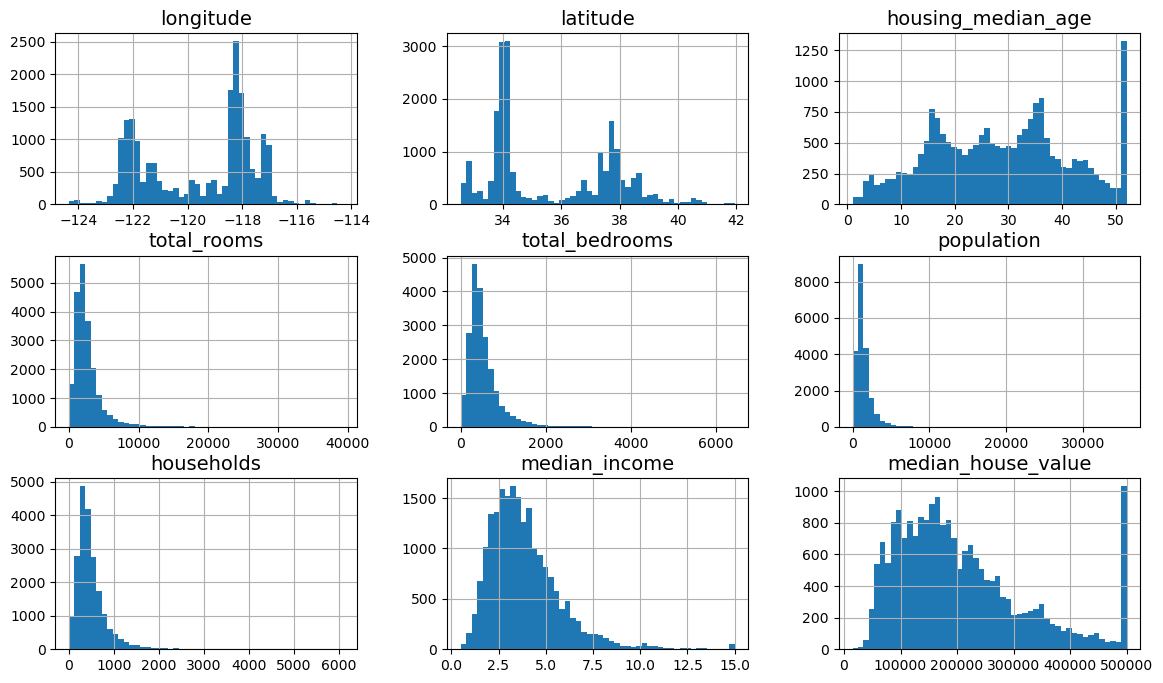

In [49]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(14, 8))
plt.show()

Looking at these histograms, you notice a few things:


the data has been scaled and capped at 15 (actually, 15.0001) for higher median
incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers
represent roughly tens of thousands of dollars (e.g., 3 actually means about
$30,000).


The housing median age and the median house value were also capped. The
latter may be a serious problem since it is your target attribute (your labels). Your
machine learning algorithms may learn that prices never go beyond that limit ($500,000).


These attributes have very different scales.


Finally, many histograms are skewed right: they extend much farther to the
right of the median than to the left. This may make it a bit harder for some
machine learning algorithms to detect patterns. Later, you’ll try transforming
these attributes to have more symmetrical and bell-shaped distributions.


## Create a Test Set


In [50]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [51]:
import numpy as np


def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices,:], data.iloc[test_indices,:]

In [52]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


Well, this works, but it is not perfect: if you run the program again, it will generate a
different test set! Over time, you (or your machine learning algorithms) will get to see
the whole dataset, which is what you want to avoid.


To have a stable train/test split even after updating the dataset, a common solution is
to use each instance’s identifier to decide whether or not it should go in the test set
(assuming instances have unique and immutable identifiers).
